In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Grabbing the nominees
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'WRITING (Adaptation)':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    is_winner = 1
                    statement = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['statement'] = statement
                    result[film_title] = sub_result
        except Exception:
            pass
    return result



In [3]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

In [4]:
best_2016

{}

In [5]:
# Load Data
import numpy as np
import pandas as pd
# read from award
df_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','winner','movieName','filmInfo'])
df_movies = pd.read_csv('movies.csv')
df_credits = pd.read_csv('credits.csv')

In [6]:
#View data
#print(df_awards.head())
#print("")
#print(df_credits.head())

In [7]:
# append the data we scrapped to the df_awards
data = []
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])
  
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

for k,v in best_2018.items():
    row = []
    row.append(['2018', 91, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])
# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','movieName','filmInfo']),ignore_index=True)

#df_awards

In [8]:
# Data Manipulation
#Joining the dataframes
if 'title' in df_credits.columns: 
  df_credits = df_credits.drop('title',axis=1) 
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))

In [9]:
#df_credits_movies.dtypes
# Reset the data types and get the earliest date of release_date
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'])
#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03

In [10]:
# Select movies that are in Outstanding Picture or Best Picture awards category -> df_picture_awards
#join df_credits_movies and df_awards by movie name (df_credits_movies.title = df_awards.movieName)
#before that, extract BEST PICTRUE from the df_awards
df_picture_awards = df_awards.loc[df_awards['award'].isin(['Outstanding Picture','Best Picture'])]
df_picture_awards.reset_index(drop = True, inplace = True)
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]


In [11]:
# Replace all the null value in ‘winner’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_picture_awards['winner'].fillna(1,inplace = True)


In [12]:
# join df_picture_awards with df_credits_movies
#cleaning names/punctuation
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_picture_awards['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]
#then, change the title in the movie to lower case
df_picture_awards.loc[:,'movie_title'] = movieName #change the string to lower case
df_credits_movies.loc[:,'movie_title']= title
# check the dataframe, we can see the string in movie_title now is valid
print(df_picture_awards.head())

        year ceremony                award  winner               movieName  \
0  1927/1928        1  Outstanding Picture     1.0       The Caddo Company   
1  1927/1928        1  Outstanding Picture     1.0                     Fox   
2  1927/1928        1  Outstanding Picture     1.0  Paramount Famous Lasky   
3  1928/1929        2  Outstanding Picture     1.0     Feature Productions   
4  1928/1929        2  Outstanding Picture     1.0                     Fox   

         filmInfo             movie_title  
0      The Racket       the caddo company  
1      7th Heaven                     fox  
2           Wings  paramount famous lasky  
3           Alibi     feature productions  
4  In Old Arizona                     fox  


In [13]:
# join the two tables, merge the data
df = df_picture_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)
#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0

# Print master df to csv
#df.to_csv('masterList.csv', index=False)

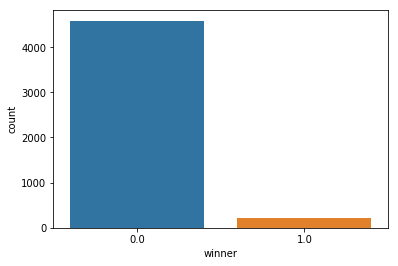

In [14]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='winner', data = df)


In [15]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['winner'] == 0])) #4586
print(len(df.loc[df['winner'] == 1])) #209

4586
209


In [16]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)

In [17]:
print(len(df_new))

609


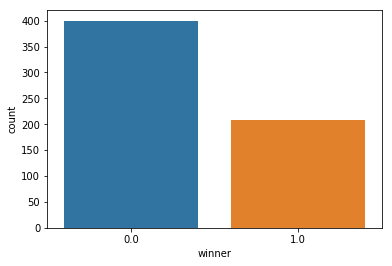

In [18]:
sns.countplot(x='winner', data = df_new)

In [19]:
#check number of null values in the dataset
df_new.isnull().sum()

movie_title             0
cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
year                    0
ceremony                0
award                   0
winner                  0
movieName               0
filmInfo                0
dtype: int64

In [20]:
#Exploratory Data Analysis

# check the data types and select numeric variables
df_new.dtypes

movie_title                     object
cast                            object
crew                            object
budget                           int64
genres                          object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
year                            object
ceremony                         int64
award                           object
winner                         float64
movieName                

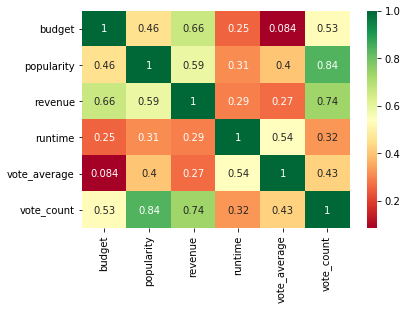

In [21]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

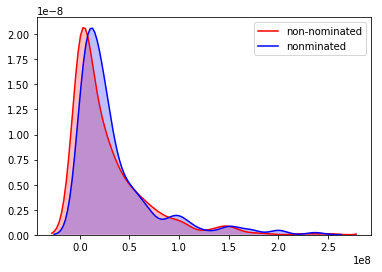

In [22]:
# Density Curve
# budget
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

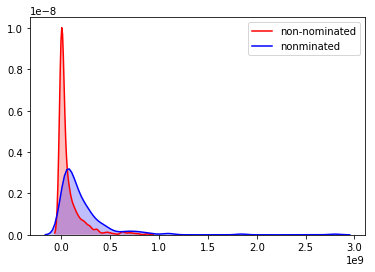

In [23]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

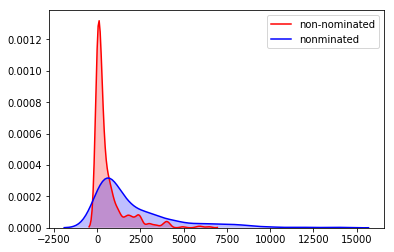

In [24]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

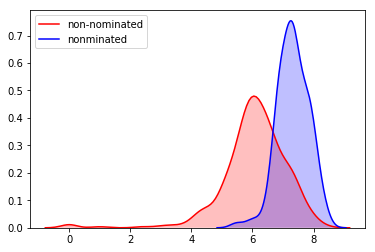

In [25]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

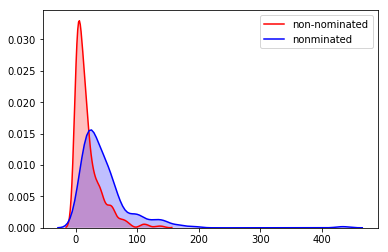

In [26]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

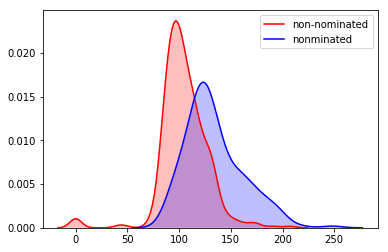

In [27]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [28]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [29]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

   Documentary    Comedy   Romance    Horror  Thriller  TV Movie   Western  \
0     0.011628  0.145349  0.090116  0.044574  0.099806  0.001938  0.005814   
1     0.000000  0.064386  0.096579  0.004024  0.078471  0.000000  0.012072   

     Family     Crime       War   History  Science Fiction  Animation  \
0  0.050388  0.058140  0.009690  0.009690         0.047481   0.020349   
1  0.020121  0.054326  0.044266  0.072435         0.018109   0.004024   

   Adventure     Music     Drama    Action   Mystery   Fantasy   Foreign  
0   0.059109  0.013566  0.174419  0.099806  0.019380  0.034884  0.003876  
1   0.054326  0.020121  0.364185  0.044266  0.020121  0.028169  0.000000  


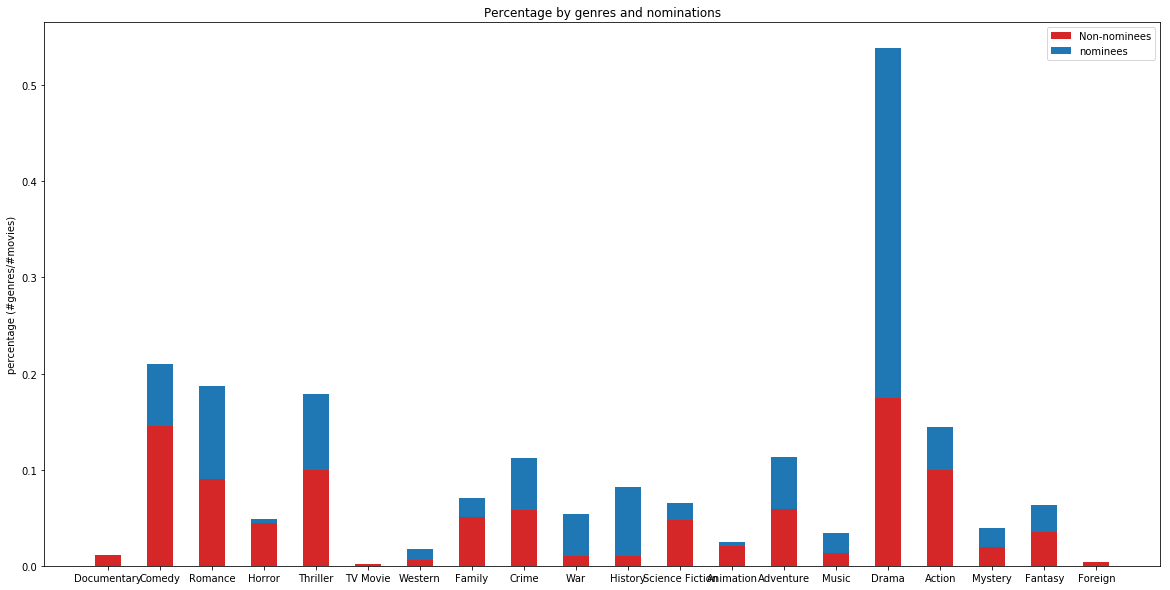

In [30]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [31]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [32]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering
df2

,movie_title,crew,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,...,Victor Verhaeghe,Paul Jude Letersky,Michael Power,Henry G. Sanders,Gruffudd Glyn,Enzo Cilenti,Billy Magnussen,Alicia Davis Johnson,Riley Paton,Zarrin Darnell-Martin
0,i want someone to eat cheese with,"[{""credit_id"": ""52fe45359251416c7504f3b5"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...","[{""id"": 10183, ""name"": ""independent film""}]",en,I Want Someone to Eat Cheese With,"Life has its downs for James, living with his ...",1.742383,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,click,"[{""credit_id"": ""52fe44e9c3a36847f80b1757"", ""de...",82500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 802, ""name"": ""regret""}, {""id"": 1022, ""...",en,Click,A workaholic architect finds a universal remot...,41.176631,"[{""name"": ""Original Film"", ""id"": 333}, {""name""...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,oceans eleven,"[{""credit_id"": ""52fe4220c3a36847f800615d"", ""de...",85000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...","[{""id"": 378, ""name"": ""prison""}, {""id"": 3430, ""...",en,Ocean's Eleven,"Less than 24 hours into his parole, charismati...",60.929352,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,beat the world,"[{""credit_id"": ""56124ed4c3a3682206002b56"", ""de...",10000000,"[{""id"": 10402, ""name"": ""Music""}, {""id"": 18, ""n...","[{""id"": 190341, ""name"": ""sporting event""}]",en,Beat the World,"Three dance crews – one Latin American, one Eu...",2.873796,"[{""name"": ""The Harold Greenberg Fund"", ""id"": 8...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,robots,"[{""credit_id"": ""52fe454bc3a36847f80c62bb"", ""de...",75000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...","[{""id"": 1436, ""name"": ""inventor""}, {""id"": 4480...",en,Robots,Rodney Copperbottom is a young robot inventor ...,29.558157,"[{""name"": ""Blue Sky Studios"", ""id"": 9383}, {""n...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,babe pig in the city,"[{""credit_id"": ""52fe44f8c3a36847f80b4ff3"", ""de...",90000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 35, ""...","[{""id"": 2206, ""name"": ""piggy bank""}, {""id"": 49...",en,Babe: Pig in the City,"Babe, fresh from his victory in the sheepherdi...",11.356079,"[{""name"": ""Kennedy Miller Productions"", ""id"": ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,hancock,"[{""credit_id"": ""52fe44cbc3a36847f80aa60f"", ""de...",150000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 334, ""name"": ""flying""}, {""id"": 567, ""n...",en,Hancock,Hancock is a down-and-out superhero who's forc...,56.758411,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,snakes on a plane,"[{""credit_id"": ""5691639ac3a36802e400064d"", ""de...",33000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 1585, ""name"": ""snake""}, {""id"": 9937, ""...",en,Snakes on a Plane,America is on the search for the murderer Eddi...,19.642328,"[{""name"": ""New Line Cinema"", ""id"": 12}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,you only live twice,"[{""credit_id"": ""52fe4267c3a36847f801bbd1"", ""de...",9500000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,You Only Live Twice,A mysterious space craft kidnaps a Russian and...,28.675891,"[{""name"": ""Eon Productions"", ""id"": 7576}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,the craft,"[{""credit_id"": ""52fe44dcc3a36847f80ae457"", ""de...",15000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 14, ""name...","[{""id"": 616, ""name"": ""witch""}, {""id"": 1252, ""n...",en,The Craft,A Catholic school newcomer falls in with a cli...,19.517239,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...

In [33]:
# director
crew_name = {}

for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)
df3

,movie_title,crew,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,...,Spike Jonze,Steve McQueen,Morten Tyldum,Ava DuVernay,James Marsh,Damien Chazelle,Adam McKay,John Crowley,Lenny Abrahamson,Tom McCarthy
0,i want someone to eat cheese with,"[{""credit_id"": ""52fe45359251416c7504f3b5"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...","[{""id"": 10183, ""name"": ""independent film""}]",en,I Want Someone to Eat Cheese With,"Life has its downs for James, living with his ...",1.742383,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,click,"[{""credit_id"": ""52fe44e9c3a36847f80b1757"", ""de...",82500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 802, ""name"": ""regret""}, {""id"": 1022, ""...",en,Click,A workaholic architect finds a universal remot...,41.176631,"[{""name"": ""Original Film"", ""id"": 333}, {""name""...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,oceans eleven,"[{""credit_id"": ""52fe4220c3a36847f800615d"", ""de...",85000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...","[{""id"": 378, ""name"": ""prison""}, {""id"": 3430, ""...",en,Ocean's Eleven,"Less than 24 hours into his parole, charismati...",60.929352,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,beat the world,"[{""credit_id"": ""56124ed4c3a3682206002b56"", ""de...",10000000,"[{""id"": 10402, ""name"": ""Music""}, {""id"": 18, ""n...","[{""id"": 190341, ""name"": ""sporting event""}]",en,Beat the World,"Three dance crews – one Latin American, one Eu...",2.873796,"[{""name"": ""The Harold Greenberg Fund"", ""id"": 8...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,robots,"[{""credit_id"": ""52fe454bc3a36847f80c62bb"", ""de...",75000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...","[{""id"": 1436, ""name"": ""inventor""}, {""id"": 4480...",en,Robots,Rodney Copperbottom is a young robot inventor ...,29.558157,"[{""name"": ""Blue Sky Studios"", ""id"": 9383}, {""n...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,babe pig in the city,"[{""credit_id"": ""52fe44f8c3a36847f80b4ff3"", ""de...",90000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 35, ""...","[{""id"": 2206, ""name"": ""piggy bank""}, {""id"": 49...",en,Babe: Pig in the City,"Babe, fresh from his victory in the sheepherdi...",11.356079,"[{""name"": ""Kennedy Miller Productions"", ""id"": ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,hancock,"[{""credit_id"": ""52fe44cbc3a36847f80aa60f"", ""de...",150000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 334, ""name"": ""flying""}, {""id"": 567, ""n...",en,Hancock,Hancock is a down-and-out superhero who's forc...,56.758411,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,snakes on a plane,"[{""credit_id"": ""5691639ac3a36802e400064d"", ""de...",33000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 1585, ""name"": ""snake""}, {""id"": 9937, ""...",en,Snakes on a Plane,America is on the search for the murderer Eddi...,19.642328,"[{""name"": ""New Line Cinema"", ""id"": 12}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,you only live twice,"[{""credit_id"": ""52fe4267c3a36847f801bbd1"", ""de...",9500000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,You Only Live Twice,A mysterious space craft kidnaps a Russian and...,28.675891,"[{""name"": ""Eon Productions"", ""id"": 7576}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,the craft,"[{""credit_id"": ""52fe44dcc3a36847f80ae457"", ""de...",15000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 14, ""name...","[{""id"": 616, ""name"": ""witch""}, {""id"": 1252, ""n...",en,The Craft,A Catholic school newcomer falls in with a cli...,19.517239,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [34]:
df3=df3.drop(['crew'],axis=1)
#genres
df4 = feature_engineering("genres", df3, "name")
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)
# drop the columns not used
df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)

In [35]:
df_clean.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,ceremony,winner,Jeff Garlin,...,sh,bs,hr,ar,he,vi,el,yi,fa,ga
0,0,1.742383,0,80.0,5.7,12,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,82500000,41.176631,237681299,107.0,6.0,2104,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85000000,60.929352,450717150,116.0,7.2,3783,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000000,2.873796,0,91.0,4.3,16,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75000000,29.558157,260696994,91.0,6.0,1333,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Model Training
# split
X = df_clean[df_clean.columns.difference(['winner'])]
print(X)
# X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=1/7.0, random_state=0)
print(X_train)

     1492 Pictures  1821 Pictures  1930s  1940s  1950s  1960s  1970s  1980s  \
0              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9              0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11             0.0            0.0    0.0    0.0    0

In [37]:
from sklearn.preprocessing import StandardScaler
print(X_train)
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

     1492 Pictures  1821 Pictures  1930s  1940s  1950s  1960s  1970s  1980s  \
12             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
380            0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
229            0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
243            0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
78             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
351            0.0            0.0    1.0    0.0    0.0    0.0    0.0    0.0   
66             0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
142            0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
350            0.0            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
92             0.0            0.0    0.0    0.0    0

In [38]:
from sklearn.decomposition import PCA
pca = PCA(0.50)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)

In [39]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
# Predict for One Observation
predicted = logisticRegr.predict(X_test)
print(logisticRegr.predict(X_test))
print(y_test.index)
# df8['movie_title'][y_test.index]

[0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
Int64Index([576,  52, 531, 345,  55,  62, 348, 304, 206, 408, 306, 492, 181,
            357, 418, 433, 443, 590, 467, 548,  48, 233, 242, 482, 187, 505,
            205, 172, 210, 311, 346, 369, 395, 222, 103, 432, 463, 530, 435,
            319, 245, 194,  14, 338, 607, 484, 587, 358,   1, 439, 339, 390,
            552, 127, 412, 190, 372, 361,   8, 193, 122, 279, 400,  17, 424,
             21, 250,  85, 455, 178, 440, 303, 602, 246,  37, 225, 378,  34,
            564,  64, 497, 391, 567, 318, 170, 491, 597],
           dtype='int64')


In [41]:
logisticRegr.score(X_train, y_train)

0.9980842911877394

In [42]:
logisticRegr.score(X_test, y_test) # 0.8850574712643678

0.7931034482758621

In [43]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
print(sensitivity) # 0.84375

0.78125


In [44]:
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg) # 0.7093223254213967
#     print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

0.694627192982456
